## Implementing CNN with TFSlim 
### Goals
* Learn how to use TFSlim

### Contents
* Building 2-layered CNN with TFSlim and batch normalization to prevent over-fitting

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import slim
import matplotlib.pyplot as plt

%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Model parameters
# input
n_input_width = 28
n_input_height = 28
n_input_channel = 1

# 1st convolutional layer
n_conv1_patch_size = 3 
n_conv1_filter = 64

# 2nd convolutional layer
n_conv2_patch_size = 3 
n_conv2_filter = 64

# fully connected output layer
n_output  = 10 

In [3]:
x = tf.placeholder(tf.float32, [None, n_input_width * n_input_height * n_input_channel])
y = tf.placeholder(tf.float32, [None, n_output])
inputs = tf.reshape(x, shape=[-1, n_input_width, n_input_width, n_input_channel])

end_points = {}

In [4]:
slim.conv2d?

In [5]:
# convolution layers with tf.slim
net = slim.conv2d(inputs, n_conv1_filter, [n_conv1_patch_size, n_conv1_patch_size], normalizer_fn=slim.batch_norm)
net = slim.max_pool2d(net, [3, 3])
end_points['conv1'] = net

net = slim.conv2d(net, n_conv2_filter, [n_conv1_patch_size, n_conv1_patch_size], normalizer_fn=slim.batch_norm)
net = slim.max_pool2d(net, [3, 3])
end_points['conv2'] = net

net = slim.flatten(net)
logits = slim.fully_connected(net, n_output, normalizer_fn=slim.batch_norm, activation_fn=None)   
end_points['logits'] = logits

In [6]:
# Print name and shape of each tensor.
print("Layers")
for k, v in end_points.items():
    print('name = {}, shape = {}'.format(v.name, v.get_shape()))

# Print name and shape of parameter nodes  (values not yet initialized)
print("\n")
print("Parameters")
for v in slim.get_model_variables():
    print('name = {}, shape = {}'.format(v.name, v.get_shape()))

Layers
name = MaxPool2D_1/MaxPool:0, shape = (?, 6, 6, 64)
name = MaxPool2D/MaxPool:0, shape = (?, 13, 13, 64)
name = fully_connected/BatchNorm/batchnorm/add_1:0, shape = (?, 10)


Parameters
name = Conv/weights:0, shape = (3, 3, 1, 64)
name = Conv/BatchNorm/beta:0, shape = (64,)
name = Conv/BatchNorm/moving_mean:0, shape = (64,)
name = Conv/BatchNorm/moving_variance:0, shape = (64,)
name = Conv_1/weights:0, shape = (3, 3, 64, 64)
name = Conv_1/BatchNorm/beta:0, shape = (64,)
name = Conv_1/BatchNorm/moving_mean:0, shape = (64,)
name = Conv_1/BatchNorm/moving_variance:0, shape = (64,)
name = fully_connected/weights:0, shape = (2304, 10)
name = fully_connected/BatchNorm/beta:0, shape = (10,)
name = fully_connected/BatchNorm/moving_mean:0, shape = (10,)
name = fully_connected/BatchNorm/moving_variance:0, shape = (10,)


In [7]:
# cost function and accuracy
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
corr = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

In [8]:
# Optimizer
learn_rate   = 0.001
optm = tf.train.AdamOptimizer(learn_rate).minimize(cost)

In [9]:
# Load dataset
mnist = input_data.read_data_sets('data/', one_hot=True)
trainImg   = mnist.train.images
trainLabel = mnist.train.labels
testImg    = mnist.test.images
testLabel  = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz


In [12]:
# Initialize the graph
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Training cycle
training_epochs = 20
batch_size      = 128

# Saver 
save_step = 10;
saver = tf.train.Saver(max_to_keep=training_epochs) 
save_cost_train = []
save_cost_test = []
save_accr_train = []
save_accr_test = []

In [13]:
# Training
for epoch in range(training_epochs):    
    cost_train_avg = 0.
    accr_train_avg = 0.
    num_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(num_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)        
        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
        # Training cost
        cost_train_avg += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/num_batch
        accr_train_avg += sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})/num_batch
        
    # Display logs per epoch step 
    save_cost_train.append(cost_train_avg)
    save_accr_train.append(accr_train_avg)
    print ("Epoch: %03d/%03d" % (epoch, training_epochs))
    print (" Train cost: %.9f accuracy: %.3f" % (cost_train_avg, accr_train_avg))
    
    # Test
    num_batch = int(mnist.test.num_examples/batch_size)
    cost_test_avg = 0.
    accr_test_avg = 0.
    for i in range(num_batch):
        batch_xs, batch_ys = mnist.test.next_batch(batch_size)
        cost_test_avg += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/num_batch
        accr_test_avg += sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})/num_batch
    
    save_cost_test.append(cost_test_avg)
    save_accr_test.append(accr_test_avg)
    print (" Test  cost: %.9f accuracy: %.3f" % (cost_test_avg, accr_test_avg))

    # Save Net
    if epoch % save_step == 0:
        saver.save(sess, "net/cnn_mnist.ckpt-" + str(epoch))

print ("Optimization Finished.")

Epoch: 000/020
 Train cost: 0.499164507 accuracy: 0.970
 Test  cost: 0.430383784 accuracy: 0.985
Epoch: 001/020
 Train cost: 0.417551923 accuracy: 0.988
 Test  cost: 0.412326107 accuracy: 0.988
Epoch: 002/020
 Train cost: 0.401793965 accuracy: 0.991
 Test  cost: 0.401750239 accuracy: 0.989
Epoch: 003/020
 Train cost: 0.393083470 accuracy: 0.992
 Test  cost: 0.397823221 accuracy: 0.991
Epoch: 004/020
 Train cost: 0.387192156 accuracy: 0.993
 Test  cost: 0.396527149 accuracy: 0.992
Epoch: 005/020
 Train cost: 0.384999803 accuracy: 0.994
 Test  cost: 0.388791650 accuracy: 0.990
Epoch: 006/020
 Train cost: 0.380185204 accuracy: 0.994
 Test  cost: 0.391750291 accuracy: 0.991
Epoch: 007/020
 Train cost: 0.377580919 accuracy: 0.995
 Test  cost: 0.384652294 accuracy: 0.991
Epoch: 008/020
 Train cost: 0.375703621 accuracy: 0.995
 Test  cost: 0.385721594 accuracy: 0.991
Epoch: 009/020
 Train cost: 0.373923159 accuracy: 0.995
 Test  cost: 0.381278959 accuracy: 0.991
Epoch: 010/020
 Train cost: 0.

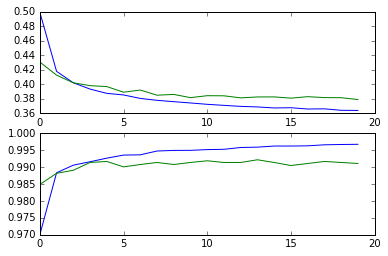

In [14]:
# Traininig curve
epochs = range(training_epochs)
plt.subplot(211)
plt.plot(epochs, save_cost_train, epochs, save_cost_test)
plt.subplot(212)
plt.plot(epochs, save_accr_train, epochs, save_accr_test)

In [15]:
np.argmin(save_cost_test)

19